<a href="https://colab.research.google.com/github/JDiogoRiveroFreitas/AlgoritmosOptmizacion-03MIAR/blob/main/TrabajoPr%C3%A1ctico_DiogoRivero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmos de optimización - Trabajo Práctico
## Algoritmos de Optimización, Máster en Inteligencia Artificial, VIU
> **José Diogo Rivero Freitas**

Notebook en Google Colab: https://colab.research.google.com/drive/18DBinvdMg4fXarxJUEuH_ZRO3FdvvhR6?usp=sharing <br>
Repositorio de la asignatura en GitHub: https://github.com/JDiogoRiveroFreitas/AlgoritmosOptmizacion-03MIAR.git
<br>
Repositorio del trabajo práctico: https://github.com/JDiogoRiveroFreitas/AlgoritmosOptmizacion-03MIAR/tree/961b7ffd1ca0d4ac8e94a25bcdf10a3a42cf277f/Proyecto%20Pr%C3%A1ctico <br>

Problema:
- Organizar los horarios de partidos de La Liga







                                        

**Descripción del problema:** <br>
Desde la La Liga de fútbol profesional se pretende organizar los horarios de los partidos de liga de cada jornada. Se conocen algunos datos que nos deben llevar a diseñar un algoritmo que realice la asignación de los partidos a los horarios de forma que maximice la audiencia. Los horarios disponibles se conocen a priori y son los siguientes: <br>

| Día     | Horario     |
|---------|-------------|
| Viernes | 20          |       
| Sábado  | 12,16,18,20 |           
| Domingo | 12,16,18,20 |            
| Lunes   | 20          |           


En primer lugar se clasifican los equipos en tres categorías según el numero de seguidores( que tiene relación directa con la audiencia). Hay 3 equipos en la categoría A, 11 equipos de categoría B y 6 equipos de categoría C. Se conoce estadísticamente la audiencia que genera cada partido según los equipos que se enfrentan y en horario de sábado a las 20h (el mejor en todos los casos)

|                   | Categoría A | Categoría B   | Categoría C   |
|-------------------|-------------|---------------|---------------|
| Categoría A       | 2 millones  | 1,3 millones  | 1 millones    |
| Categoría B       |             | 0,9 millones  | 0,75 millones |
| Categoría C       |             |               | 0,47 millones |


Si el horario del partido no se realiza a las 20 horas del sábado se sabe que se reduce según los coeficientes de la siguiente tabla. Debemos asignar obligatoriamente siempre un partido el viernes y un partido el lunes


|      | Viernes |  Sábado   | Domingo   | Lunes   |
|------|---------|-----------|-----------|---------|
| 12h  |         | 0,55      | 0,45      |         |
| 16h  |         | 0,7       | 0,75      |         |
| 18h  |         | 0,8       | 0,85      |         |
| 20h  |0,4      | 1         | 1         |0,4      |

Es posible la coincidencia de horarios pero en este caso la audiencia de cada partido se verá afectada y se estima que se reduce en porcentaje según la siguiente tabla dependiendo del número de coincidencias:

| Coincidencias| -%  |
|--------------|-----|
| 0            |  0% |
| 1            | 25% |
| 2            | 45% |
| 3            | 60% |
| 4            | 70% |
| 5            | 75% |
| 6            | 78% |
| 7            | 80% |
| 8            | 80% |

#**Modelo**
## - ¿Como represento el espacio de soluciones?
El concepto que planteo desde un inicio, es trabajar con dataframes de la librería pandas. Las soluciones candidatas a óptimas serán listas, las cuales se implementen al dataframe para que se procese el resultado de cada propuesta con la función objetivo.

## - ¿Cual es la función objetivo?
> ∑ factor_categoría * factor_horario * factor_coincidencia

## - ¿Como implemento las restricciones?
En este problema las restricciones impuestas son:
- Debe haber al menos un partido el **viernes** a las 20:00.
- Debe haber al menos un partido el **lunes** a las 20:00.

Para que estas se cumplan, en el generador de propuestas se forzará a que se cumplan y en posteriores etapas se manipularan las propuestas de modo que no se pierdan estos 2 elementos.

A continuación se formulan las bases del algoritmo

In [ ]:
# Importaciones

import pandas as pd
import random
random.seed(42)

In [ ]:
# Se añaden todos los factores expuestos en el enunciado

fact_category = {'AA': 2, 'BA': 1.3, 'BB':0.9, 'BC':0.75, 'CC':0.47}
fact_schedule = {'V20': 0.4,'S12': 0.55,'S16': 0.7, 'S18': 0.8, 'S20': 1, 'D12': 0.45, 'D16': 0.75, 'D18': 0.85, 'D20': 1, 'L20': 0.4}
fact_coincidence= {0:1, 1: 0.75, 2: 0.55, 3: 0.4, 4: 0.3, 5: 0.25, 6: 0.22, 7: 0.2, 8: 0.2, 9: 0.2}

#**Análisis**
## - ¿Que complejidad tiene el problema?. Orden de complejidad y contabilizar el espacio de soluciones.
Si no tenemos en cuenta las restricciones y hacemos uso de la combinatoria, este problema contaría con las siguientes características:
- No se toman todos los elementos iniciales. Esto es debido a que tomamos como elementos a los horarios, y es posible poner todos los partidos el mismo día y a la misma hora.
- El orden importa. Ya que si tomamos los partidos en un orden y tenemos en cuenta a los aficionados, no es lo mismo poner un partido en la franja de mayor audiencia los partidos de categoría AA que CC.
- Es posible la repetición, por la misma jsutificación que en el primer punto.
Por lo tanto, estamos frente a una **variación con repetición**. Si lo aplicamos a nuestro problema:
> VR = m^n = 10^10

Las restricciones en este caso son que debe haber obligatoriamente como mínimo un partido el viernes y lunes.
Por lo que se plantea de la siguiente manera:
- Tomamos como elementos a los partidos.
- Al viernes le asignamos un partido de los diez, por lo tanto quedan 9 sin asignar.
- Al lunes le asignamos un partido de los nueve, siendo 8 los restantes.
- En este momento hemos cumplido las restricciones por lo que podemos asignar el resto de partidos como en el apartado anterior.
Por lo que:
> Posibilidades = 10 * 9 * 10^8 = 9 * 10^9

Para hacer este problema mediante fuerza bruta, una opción sería poner de forma consecutiva 10 bucles for que recorran las opciones horarias posibles y en el último poner dos bloques de condición if para que se añadan a la lista de soluciones sólo las propuestas que cumplan las restricciones.<br>
\* Se ha intentado hacer esto para obtener el resultado óptimo de cara a tener un objetivo, pero resulta muy difícil por tiempo y hardware.


In [ ]:
# La base del algoritmo será un algoritmo al que se le adjuntará la propuesta
# con una lista para de este modo evaluar la propuesta.

# Se definen los partidos y sus categorías
matches = [['Celta_RMadrid', 'BA'], ['Valencia_RSociedad', 'BA'],
           ['Mallorca_Eibar', 'CC'], ['Athletic_Barcelona', 'BA'],
           ['Leganés_Osasuna', 'CC'], ['Villareal_Granada', 'BC'],
           ['Alaves_Levante', 'BB'], ['Espanyol_Sevilla', 'BB'],
           ['Betis_Valladolid', 'BC'], ['Atlético_Getafe','BB']]

# Se crea el dataframe con dos columnas, partido y categorías
df_matches_init = pd.DataFrame(matches, columns=['Match', 'Category'])

# El siguiente bloque se emplea para mostrar la audiencia. Esta se sabe gracias
# al diccionario de "fact_category"
attendance = []
for i in range(0, len(df_matches_init['Category'])):
    attendance.append(fact_category[df_matches_init['Category'][i]])

df_matches_init['Attendance'] = attendance

# Se muestra en pantalla el dataframe base
display(df_matches_init)


,Match,Category,Attendance
0,Celta_RMadrid,BA,1.30
1,Valencia_RSociedad,BA,1.30
2,Mallorca_Eibar,CC,0.47
3,Athletic_Barcelona,BA,1.30
4,Leganés_Osasuna,CC,0.47
5,Villareal_Granada,BC,0.75
6,Alaves_Levante,BB,0.90
7,Espanyol_Sevilla,BB,0.90
8,Betis_Valladolid,BC,0.75
9,Atlético_Getafe,BB,0.90


#**Diseño**
## - ¿Que técnica utilizo? ¿Por qué?
Se emplearán algoritmos genéticos, justificación:
-
- Motivos personales/profesionales. En breves, para una aplicación de optimización de control en un proyecto laboral tendré que implementar algoritmos genéticos, por lo que me parace un buen momento para aplicar los conocimientos en la práctica (afianzando estos) y tener una toma de contacto controlada.



1.   Inicialización
2.   Evaluación <br>
Durante el número definido de generaciones:
  3.   Selección
  4.   Cruce
  5.   Mutación




### 1. Inicialización

In [ ]:
def generator(num: int):
    '''
    Función generadora de propuestas (inializador)

    num -> tamaño de la muestra
    '''
    proposal = []
    for i in range(0, num):
        schedule = []
        # De la siguiente lista se disponen aleatoriamente los elementos, dando una
        # lista con 10 elementos
        schedule_options = ['S12', 'S16', 'S18', 'S20', 'D12', 'D16', 'D18', 'D20']
        for j in range(0, 10):
            schedule.append(random.choice(schedule_options))

        # Se definen aleatoriamente la posición en la lista del horario de viernes y lunes
        pos_v = random.randint(0,9)
        pos_l = random.randint(0,9)

        # El caso de que las posiciones sean las mismas es problemático
        # Por lo que se interan hasta que sean distintos

        while pos_v == pos_l:
            pos_l = random.randint(0,9)

        schedule[pos_v] = 'V20'
        schedule[pos_l] = 'L20'


        proposal.append(schedule)

    return proposal

In [ ]:
# Se comprueba el correcto funcionamiento de la función de evaluación
generator(3)

[['V20', 'L20', 'D12', 'S20', 'S20', 'S18', 'S16', 'S16', 'D18', 'S12'],
 ['S20', 'S20', 'S12', 'S20', 'D18', 'L20', 'V20', 'D12', 'S12', 'S18'],
 ['D12', 'S18', 'S20', 'D16', 'L20', 'S16', 'D18', 'S16', 'D16', 'V20']]

### 2. Evalaución

In [ ]:
# Función de evalaución

def evaluation(proposed_journey: list):
    '''
    Función para obtener resultado de la función objetivo

    proposed_journey -> lista con los horarios de la jornada
    '''

    # Se copia el dataframe base para no alterarlo
    df_matches = df_matches_init.copy()

    # Se añade la asignación de horarios propuesta
    df_matches['Schedule'] = proposed_journey

    # Se añade el factor de cada horario
    schedule_factor = []
    for i in range(0, len(df_matches['Schedule'])):
        schedule_factor.append(fact_schedule[df_matches['Schedule'][i]])

    df_matches['Factor schedule'] = schedule_factor

    # Se cuenta cuantos partidos tienen el mismo horario
    schedule_count = {'V20': 0,'S12': 0,'S16': 0, 'S18': 0, 'S20': 0, 'D12': 0, 'D16': 0, 'D18': 0, 'D20': 0, 'L20': 0}
    for date in df_matches['Schedule']:
        schedule_count[str(date)] += 1

    # Se añade el número de coincidencias de cada partido
    coincidence = []
    for i in range(0, len(df_matches['Schedule'])):
        coincidence.append(schedule_count[df_matches['Schedule'][i]] - 1)

    df_matches['Coincidence'] = coincidence

    # Se añade el factor de coincidencia
    coincidence_factor = []
    for i in range(0, len(df_matches['Schedule'])):
        coincidence_factor.append(fact_coincidence[df_matches['Coincidence'][i]])

    df_matches['Factor coincidence'] = coincidence_factor

    # Se calcula y añade la audiencia de cada partido con sus respectivos factores
    result = []
    for i in range(0, len(df_matches['Schedule'])):
        result.append(df_matches['Attendance'][i] * df_matches['Factor schedule'][i] * df_matches['Factor coincidence'][i])

    df_matches['Result'] = result

    # Sumando todos los resultados parciales obtenemos la solución a la función objetivo
    proposed_result = sum(df_matches['Result'])

    # Se devuelve el resultado de la función objetivo
    return proposed_result, df_matches

In [ ]:
# Se comprueba el correcto funcionamiento de la función de evaluación
evaluation(['V20', 'S16', 'S18', 'S20', 'D12', 'D16', 'D18', 'D20', 'D20', 'L20'])[0]

6.2425

### 3. Selección

In [ ]:
def seleccion_padres(resultados: list):
   resultados_top = resultados[0:int(len(resultados))]
   return resultados_top

In [ ]:
test = []
i = 0

for jornada in generator(5):
    test.append((i, jornada))
    i += 1

In [ ]:
seleccion_padres(test)

[(0, ['S12', 'D20', 'S16', 'V20', 'L20', 'D12', 'D16', 'S20', 'S16', 'S12']),
 (1, ['S16', 'S20', 'S16', 'V20', 'L20', 'D20', 'D16', 'S18', 'D16', 'D16']),
 (2, ['L20', 'S18', 'S20', 'V20', 'D20', 'D18', 'D12', 'S20', 'D16', 'S12']),
 (3, ['D16', 'D18', 'V20', 'S16', 'L20', 'D16', 'S20', 'D20', 'D18', 'D20']),
 (4, ['V20', 'L20', 'D12', 'D18', 'D18', 'D16', 'S20', 'S18', 'D20', 'S16'])]

### 4. Cruce

In [ ]:
# No estoy seguro si es una buena idea, no he tenido tiempo de probar alternativas

def combination(resultados_top: list):
  '''
  Función de cruce entre las propuestas de la generación anterior

  resultados_top -> lista de las propuestas seleccionadas
  '''
  nuevos_individuos = []
  padre = resultados_top[0][1]
  index_viernes = padre.index('V20')
  index_lunes = padre.index('L20')
  for prop in resultados_top:
    madre = prop[1]
    # Tomamos los elementos de 0 hasta V20 o L20 (lo que esté antes) del padre
    # Desde el indice anterior hasta el otro (V20 o L20) de la madre
    # Desde este último hasta el final
    # Con esto conseguimos que V20 y L20 se mantengan en la misma posición
    if index_viernes < index_lunes:
        nuevo_individuo = padre[0:index_viernes + 1] + madre[index_viernes + 1:index_lunes] + padre[index_lunes:10]
    else:
        nuevo_individuo = padre[0:index_lunes + 1] + madre[index_lunes + 1:index_viernes] + padre[index_viernes:10]

    nuevos_individuos.append(nuevo_individuo)

  return nuevos_individuos

In [ ]:
combination(test)

[['S12', 'D20', 'S16', 'V20', 'L20', 'D12', 'D16', 'S20', 'S16', 'S12'],
 ['S12', 'D20', 'S16', 'V20', 'L20', 'D12', 'D16', 'S20', 'S16', 'S12'],
 ['S12', 'D20', 'S16', 'V20', 'L20', 'D12', 'D16', 'S20', 'S16', 'S12'],
 ['S12', 'D20', 'S16', 'V20', 'L20', 'D12', 'D16', 'S20', 'S16', 'S12'],
 ['S12', 'D20', 'S16', 'V20', 'L20', 'D12', 'D16', 'S20', 'S16', 'S12']]

### 5. Mutación

In [ ]:
# Aquí creo que es el punto donde tengo mayor margen de mejora
# Las mutaciones no me parecen correctas al 100%
# La idea final es que tome el cruce y cambie solo uno de los horarios de la
# jornada (pero no pueden ser ni V20 ni L20)

def mutation(nuevos_individuos: list):
  '''
  Función mutación

  nuevos_individuos -> propuestas generadas tras el cruce
  '''
  sin_mutar = nuevos_individuos[0:int((len(nuevos_individuos)/2))]
  mutados1 = nuevos_individuos[int((len(nuevos_individuos)/2)):int(((len(nuevos_individuos)/2)+len(nuevos_individuos)/4))]
  schedule_options = ['S12', 'S16', 'S18', 'S20', 'D12', 'D16', 'D18', 'D20']
  for mutado in mutados1:
      for horario in mutado:
        if horario != 'V20':
          if horario != 'L20':
            mutado[mutado.index(horario)] = random.choice(schedule_options)
  # Aportamos individuos totalmente nuevos
  mutados2 = generator(int(len(nuevos_individuos) - ((len(nuevos_individuos)/2)+len(nuevos_individuos)/4)))
  nuevos_individuos_mutados = sin_mutar + mutados1 + mutados2
  return nuevos_individuos_mutados

In [ ]:
mutation(combination(seleccion_padres(test)))

[['S12', 'D20', 'S16', 'V20', 'L20', 'D12', 'D16', 'S20', 'S16', 'S12'],
 ['S12', 'D20', 'S16', 'V20', 'L20', 'D12', 'D16', 'S20', 'S16', 'S12'],
 ['S18', 'S18', 'D18', 'V20', 'L20', 'D20', 'D18', 'D18', 'S16', 'D12'],
 ['S12', 'S16', 'D12', 'D16', 'V20', 'D12', 'D18', 'S18', 'L20', 'S12']]

## Algoritmo genético

In [ ]:
from tqdm.auto import tqdm

def algoritmo_gene(tamaño_poblacion: int, epoc: int):
  '''
  Función de optimización basada en algoritmos genéticos

  tamaño_población -> número de propuestas de cada generación
  epoc -> número de generaciones
  '''
  resultados = []
  for poblacion in generator(tamaño_poblacion):
      resultados.append([evaluation(poblacion)[0], poblacion])

  resultados.sort(reverse = True)

  resultado_total = []
  resultado_total.append(resultados[0] + [0])

  for i in tqdm(range(0, epoc)):
      x = seleccion_padres(resultados)
      y = combination(x)
      z = mutation(y)
      resultados = []
      # z = mutacion(cruce(seleccion_padres(resultados)))
      for poblacion in z:
          resultados.append([evaluation(poblacion)[0], poblacion])
      resultados.sort(reverse = True)
      resultado_total.append(resultados[0] + [i+1])
      #Barra de progreso
      print(" ", end = '\r')

  return resultado_total

In [ ]:
# Esta configuración ejecutada en el Macbook Pro (M3 Pro)
# dura 20 segundos

final = algoritmo_gene(200, 200)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
datos = []
for i in range(0, len(final)):
    datos.append(final[i][0])

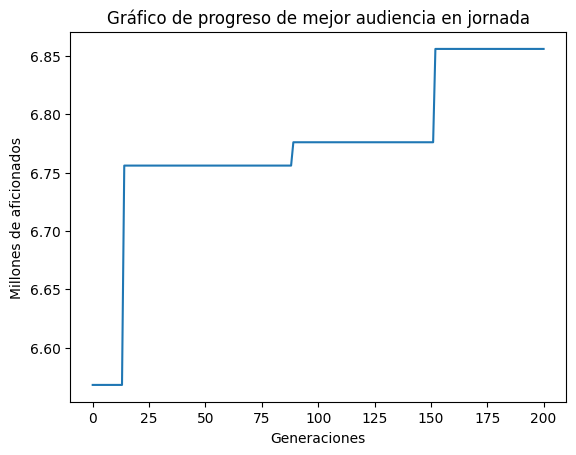

In [ ]:
import matplotlib.pyplot as plt

plt.plot(datos)
plt.xlabel('Generaciones')
plt.ylabel('Millones de aficionados')
plt.title('Gráfico de progreso de mejor audiencia en jornada')
plt.show()

## Solución encontrada

In [ ]:
print(f'La mejor jornada es con los siguinetes horarios: {final[-1][1]}')
print(f'La audiencia estimada es de {max(datos)} millones de espectadores.')

La mejor jornada es con los siguinetes horarios: ['D20', 'S20', 'V20', 'D18', 'L20', 'S12', 'D16', 'S18', 'D12', 'S16']
La audiencia estimada es de 6.856 millones de espectadores.


In [ ]:
display(evaluation(final[-1][1])[1])

,Match,Category,Attendance,Schedule,Factor schedule,Coincidence,Factor coincidence,Result
0,Celta_RMadrid,BA,1.30,D20,1.00,0,1,1.3000
1,Valencia_RSociedad,BA,1.30,S20,1.00,0,1,1.3000
2,Mallorca_Eibar,CC,0.47,V20,0.40,0,1,0.1880
3,Athletic_Barcelona,BA,1.30,D18,0.85,0,1,1.1050
4,Leganés_Osasuna,CC,0.47,L20,0.40,0,1,0.1880
5,Villareal_Granada,BC,0.75,S12,0.55,0,1,0.4125
6,Alaves_Levante,BB,0.90,D16,0.75,0,1,0.6750
7,Espanyol_Sevilla,BB,0.90,S18,0.80,0,1,0.7200
8,Betis_Valladolid,BC,0.75,D12,0.45,0,1,0.3375
9,Atlético_Getafe,BB,0.90,S16,0.70,0,1,0.6300


## Conclusiones
Viendo la solución, para este caso en concreto se podría haber usado una técnica voraz, ya que se puede apreciar que se ordenando el factor del horario se ordena también la audiencia según categorías . <br>
Además se puede concluir que pueden haber otras combinaciones posibles, por ejemplo, podemos cambiar sin problema los partidos del horario 'D20', 'S20' y 'D18' sin repercutir, dado que son de categorías 'BA'. Recalco, para estos partidos.

In [ ]:
ordenado = evaluation(final[-1][1])[1].copy()
ordenado.sort_values(by= ["Factor schedule"], inplace = True, ascending=False)
display(ordenado)

,Match,Category,Attendance,Schedule,Factor schedule,Coincidence,Factor coincidence,Result
0,Celta_RMadrid,BA,1.30,D20,1.00,0,1,1.3000
1,Valencia_RSociedad,BA,1.30,S20,1.00,0,1,1.3000
3,Athletic_Barcelona,BA,1.30,D18,0.85,0,1,1.1050
7,Espanyol_Sevilla,BB,0.90,S18,0.80,0,1,0.7200
6,Alaves_Levante,BB,0.90,D16,0.75,0,1,0.6750
9,Atlético_Getafe,BB,0.90,S16,0.70,0,1,0.6300
5,Villareal_Granada,BC,0.75,S12,0.55,0,1,0.4125
8,Betis_Valladolid,BC,0.75,D12,0.45,0,1,0.3375
2,Mallorca_Eibar,CC,0.47,V20,0.40,0,1,0.1880
4,Leganés_Osasuna,CC,0.47,L20,0.40,0,1,0.1880


Febrero 2024.